In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.decomposition import PCA

import warnings

In [2]:
data = pd.read_csv("Table-3-17.csv").drop(51).set_index("State")
data = pd.concat([data.Sales, data.drop("Sales", axis=1)], axis = 1)

#### Consider the Cigarette Consumption data described in Exercise 3.15 and given in Table 3.17. The organization wanted to construct a regression equation that relates statewide cigarette consumption (per capita basis) to various socioeconomic and demographic variables, and to de- termine whether these variables were useful in predicting the consumption of cigarettes.
- (a) Construct a linear regression model that explains the per capita sale of cigarettes in a given state. In your analysis, pay particular attention to outliers. See if the deletion of an outlier affects your findings. Look at residual plots before deciding on a final model. You need not include all the variables in the model if your analysis indicates otherwise. Your objective should be to find the smallest number of variables that describes the state sale of cigarettes meaningfully and adequately.
- (b) Write a report describing your findings.
- Variables <br>


| Variable | Definition |
|------|------|
|   Age  |  Median age of a person living in a state |
|   HS  | Percentage of people over 25 years of age in a state who had completed high school |
|   Income  | Per capita personal income for a state(income in dollars)|
|   Black  | Percentage of blacks living in a state|
|   Female  | Percentage of females living in a state |
|   Price  |Weighted average price(in cents) of a pack of cigarettes in a state |
|   Sales  | Number of packs of cigarettes sold in a state on a per capita basis|


#### 파생변수 생각해볼것. 
- Price / Income : 담배 구매력 지수(IPP)
- Female과 Black 의 경우 HS와 음의 상관관계가 있음 : 이 데이터가 구성된 지역들은 여성과 흑인이 차별받는 경향성 --> 그럼 어떤 파생변수를 만듦?
- Female과 AGE는 양의 상관관계를 가지고 있음. Why?? 여자가 많으면 중위수가 올라간다 => 여성의 나이대가 더 높은 편이기때문이라는 추측 가능
- 하지만 여성의 비율은 애초에 변동이 매우 작아 거의 degenerate 분포와 같은 형태를 보임. 이것의 문제는?
- 여성 변수가 다른 변수들과 상관관계가 높은 경우가 많음. 그렇다면 여성을 어떻게 처리해야하는가?
- 여성 관련한 파생변수... 여성비율에 따른 흡연율 ??

In [3]:
round(data.describe(),2)

,Sales,Age,HS,Income,Black,Female,Price
count,51.00,51.00,51.00,51.00,51.00,51.00,51.00
mean,121.54,27.47,53.15,3763.71,9.99,50.95,38.07
std,32.07,1.88,8.00,594.72,12.65,1.11,4.13
min,65.50,22.90,37.80,2626.00,0.20,45.70,29.00
25%,105.35,26.40,48.30,3271.00,1.60,50.75,34.70
50%,119.00,27.40,53.30,3751.00,6.00,51.10,38.90
75%,124.55,28.75,59.10,4116.50,13.55,51.50,41.35
max,265.70,32.30,67.30,5079.00,71.10,53.50,45.50


In [4]:
round(data.corr(),2).style.background_gradient(cmap='coolwarm')

,Sales,Age,HS,Income,Black,Female,Price
Sales,1,0.23,0.07,0.33,0.19,0.15,-0.3
Age,0.23,1,-0.1,0.26,-0.04,0.55,0.25
HS,0.07,-0.1,1,0.53,-0.5,-0.42,0.06
Income,0.33,0.26,0.53,1,0.02,-0.07,0.21
Black,0.19,-0.04,-0.5,0.02,1,0.45,-0.15
Female,0.15,0.55,-0.42,-0.07,0.45,1,0.02
Price,-0.3,0.25,0.06,0.21,-0.15,0.02,1


In [5]:
round(data.drop("Female", axis=1).corr(),2).style.background_gradient(cmap='coolwarm')

,Sales,Age,HS,Income,Black,Price
Sales,1,0.23,0.07,0.33,0.19,-0.3
Age,0.23,1,-0.1,0.26,-0.04,0.25
HS,0.07,-0.1,1,0.53,-0.5,0.06
Income,0.33,0.26,0.53,1,0.02,0.21
Black,0.19,-0.04,-0.5,0.02,1,-0.15
Price,-0.3,0.25,0.06,0.21,-0.15,1


In [6]:
data['IPP'] = data.Income/data.Price

In [7]:
round(data.corr(),2).style.background_gradient(cmap='coolwarm')

,Sales,Age,HS,Income,Black,Female,Price,IPP
Sales,1,0.23,0.07,0.33,0.19,0.15,-0.3,0.51
Age,0.23,1,-0.1,0.26,-0.04,0.55,0.25,0.09
HS,0.07,-0.1,1,0.53,-0.5,-0.42,0.06,0.43
Income,0.33,0.26,0.53,1,0.02,-0.07,0.21,0.75
Black,0.19,-0.04,-0.5,0.02,1,0.45,-0.15,0.15
Female,0.15,0.55,-0.42,-0.07,0.45,1,0.02,-0.05
Price,-0.3,0.25,0.06,0.21,-0.15,0.02,1,-0.48
IPP,0.51,0.09,0.43,0.75,0.15,-0.05,-0.48,1


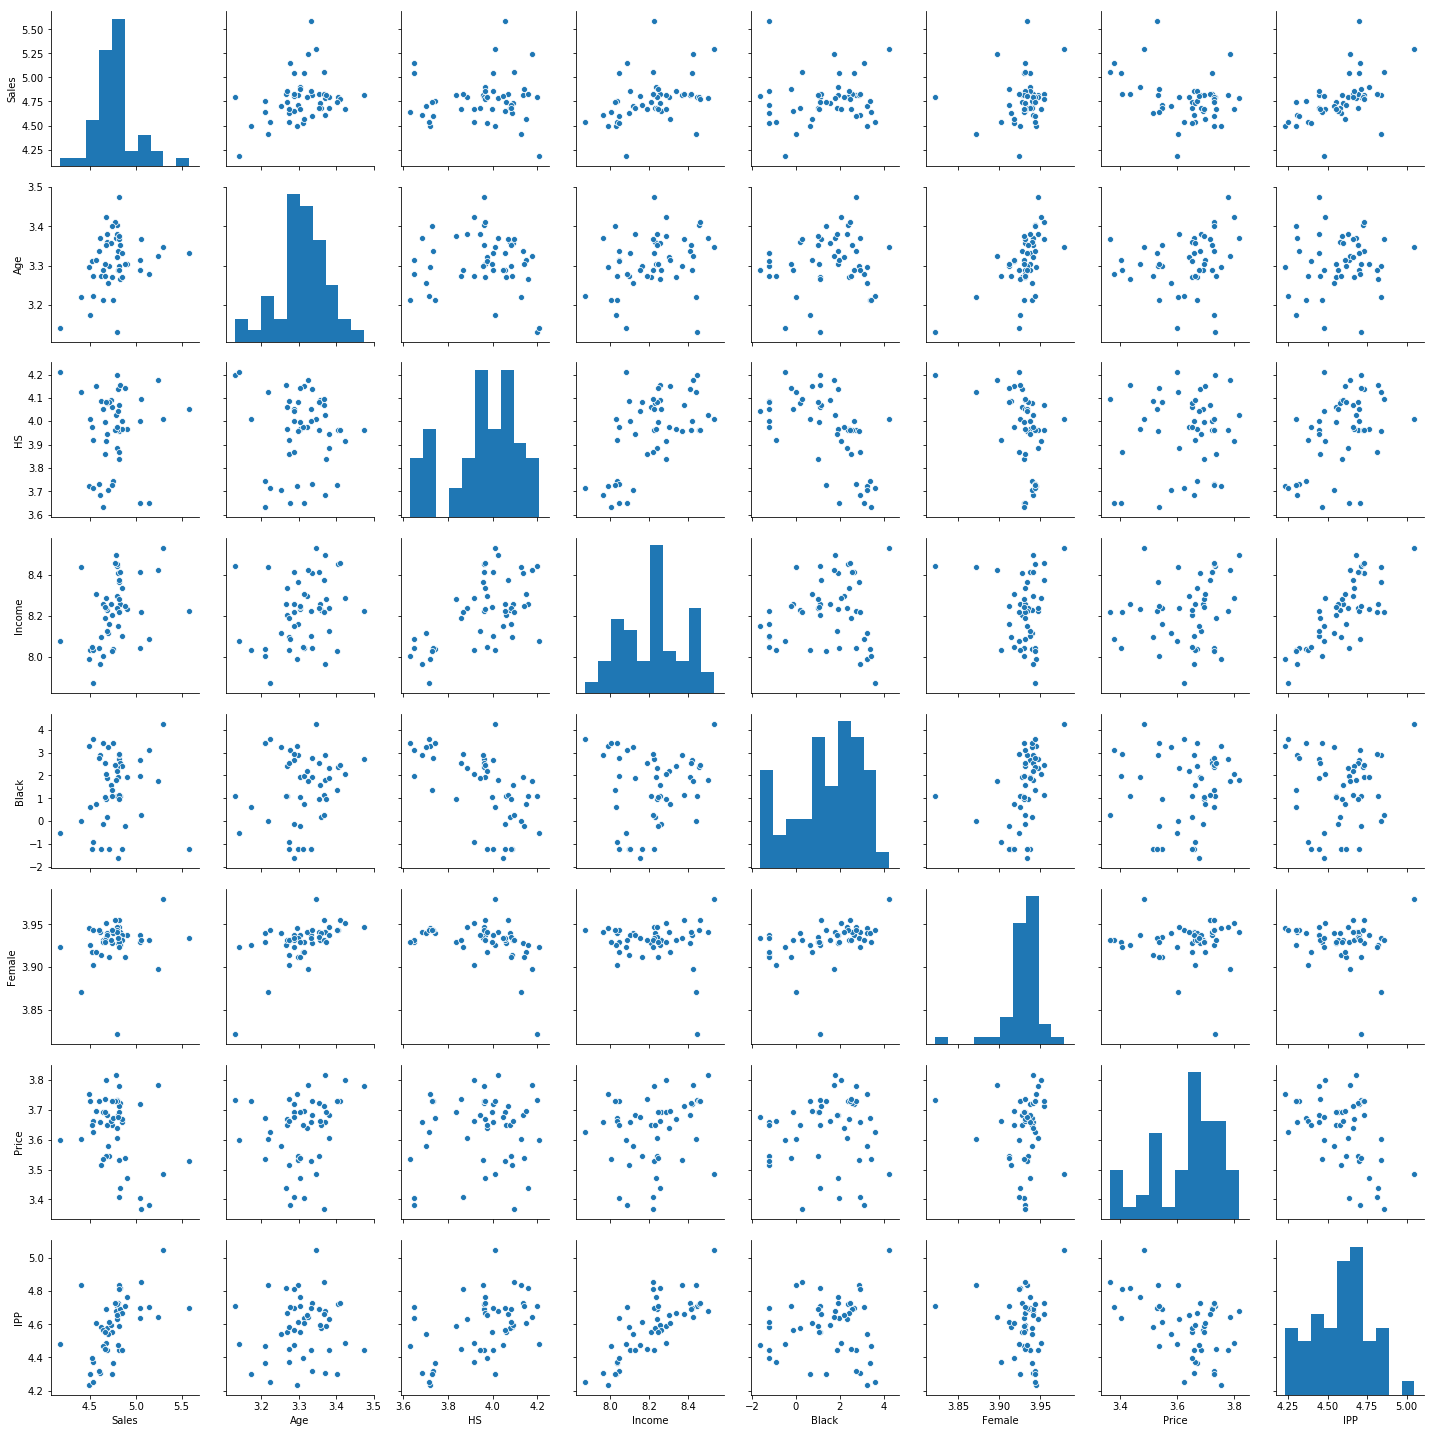

In [8]:
sns.pairplot(np.log(data))

In [9]:
Target = data.Sales
Variables = data.drop("Sales", axis=1)

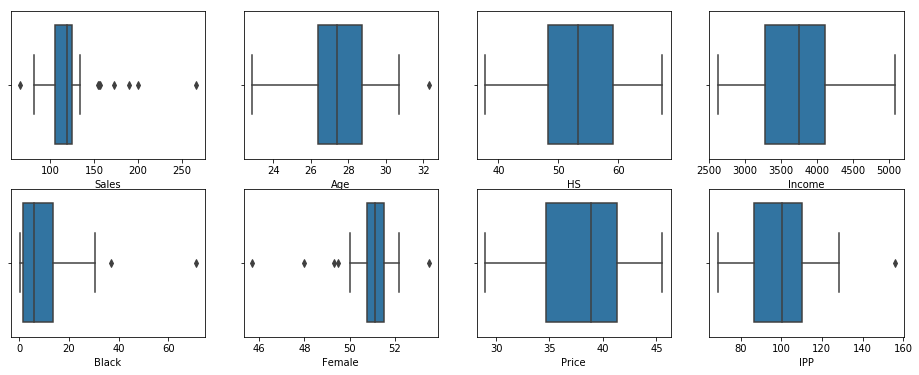

In [10]:
fig = plt.figure(figsize=(len(data.columns)*2, 6))
idx = 1
for li in data.columns :
    ax = fig.add_subplot(2, len(data.columns)/2,idx)
    sns.boxplot(data = data, x = li)
    idx += 1

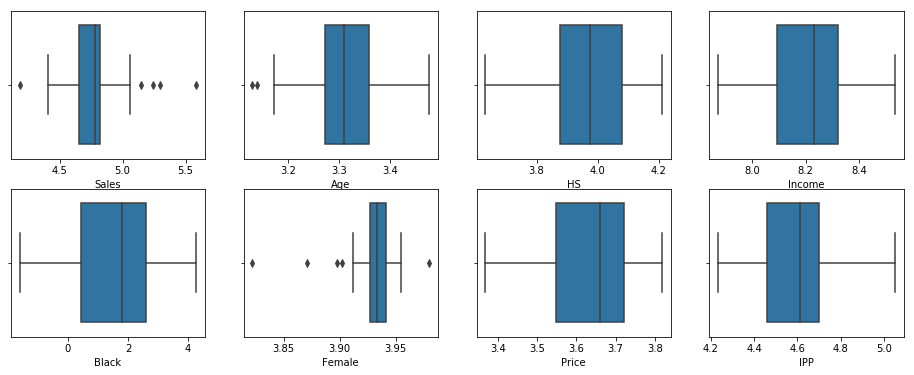

In [11]:
fig = plt.figure(figsize=(len(data.columns)*2, 6))
idx = 1
for li in data.columns :
    ax = fig.add_subplot(2, len(data.columns)/2,idx)
    sns.boxplot(data = np.log(data), x = li)
    idx += 1

In [12]:
round(np.log(data).corr(),2).style.background_gradient(cmap='coolwarm')

,Sales,Age,HS,Income,Black,Female,Price,IPP
Sales,1,0.31,0.04,0.38,0.13,0.16,-0.31,0.54
Age,0.31,1,-0.07,0.27,0.12,0.56,0.21,0.1
HS,0.04,-0.07,1,0.58,-0.58,-0.38,0.08,0.47
Income,0.38,0.27,0.58,1,0.09,-0.09,0.19,0.78
Black,0.13,0.12,-0.58,0.09,1,0.4,0.05,0.04
Female,0.16,0.56,-0.38,-0.09,0.4,1,0.01,-0.09
Price,-0.31,0.21,0.08,0.19,0.05,0.01,1,-0.47
IPP,0.54,0.1,0.47,0.78,0.04,-0.09,-0.47,1


In [13]:
round(data.corr(),2).style.background_gradient(cmap='coolwarm')

,Sales,Age,HS,Income,Black,Female,Price,IPP
Sales,1,0.23,0.07,0.33,0.19,0.15,-0.3,0.51
Age,0.23,1,-0.1,0.26,-0.04,0.55,0.25,0.09
HS,0.07,-0.1,1,0.53,-0.5,-0.42,0.06,0.43
Income,0.33,0.26,0.53,1,0.02,-0.07,0.21,0.75
Black,0.19,-0.04,-0.5,0.02,1,0.45,-0.15,0.15
Female,0.15,0.55,-0.42,-0.07,0.45,1,0.02,-0.05
Price,-0.3,0.25,0.06,0.21,-0.15,0.02,1,-0.48
IPP,0.51,0.09,0.43,0.75,0.15,-0.05,-0.48,1


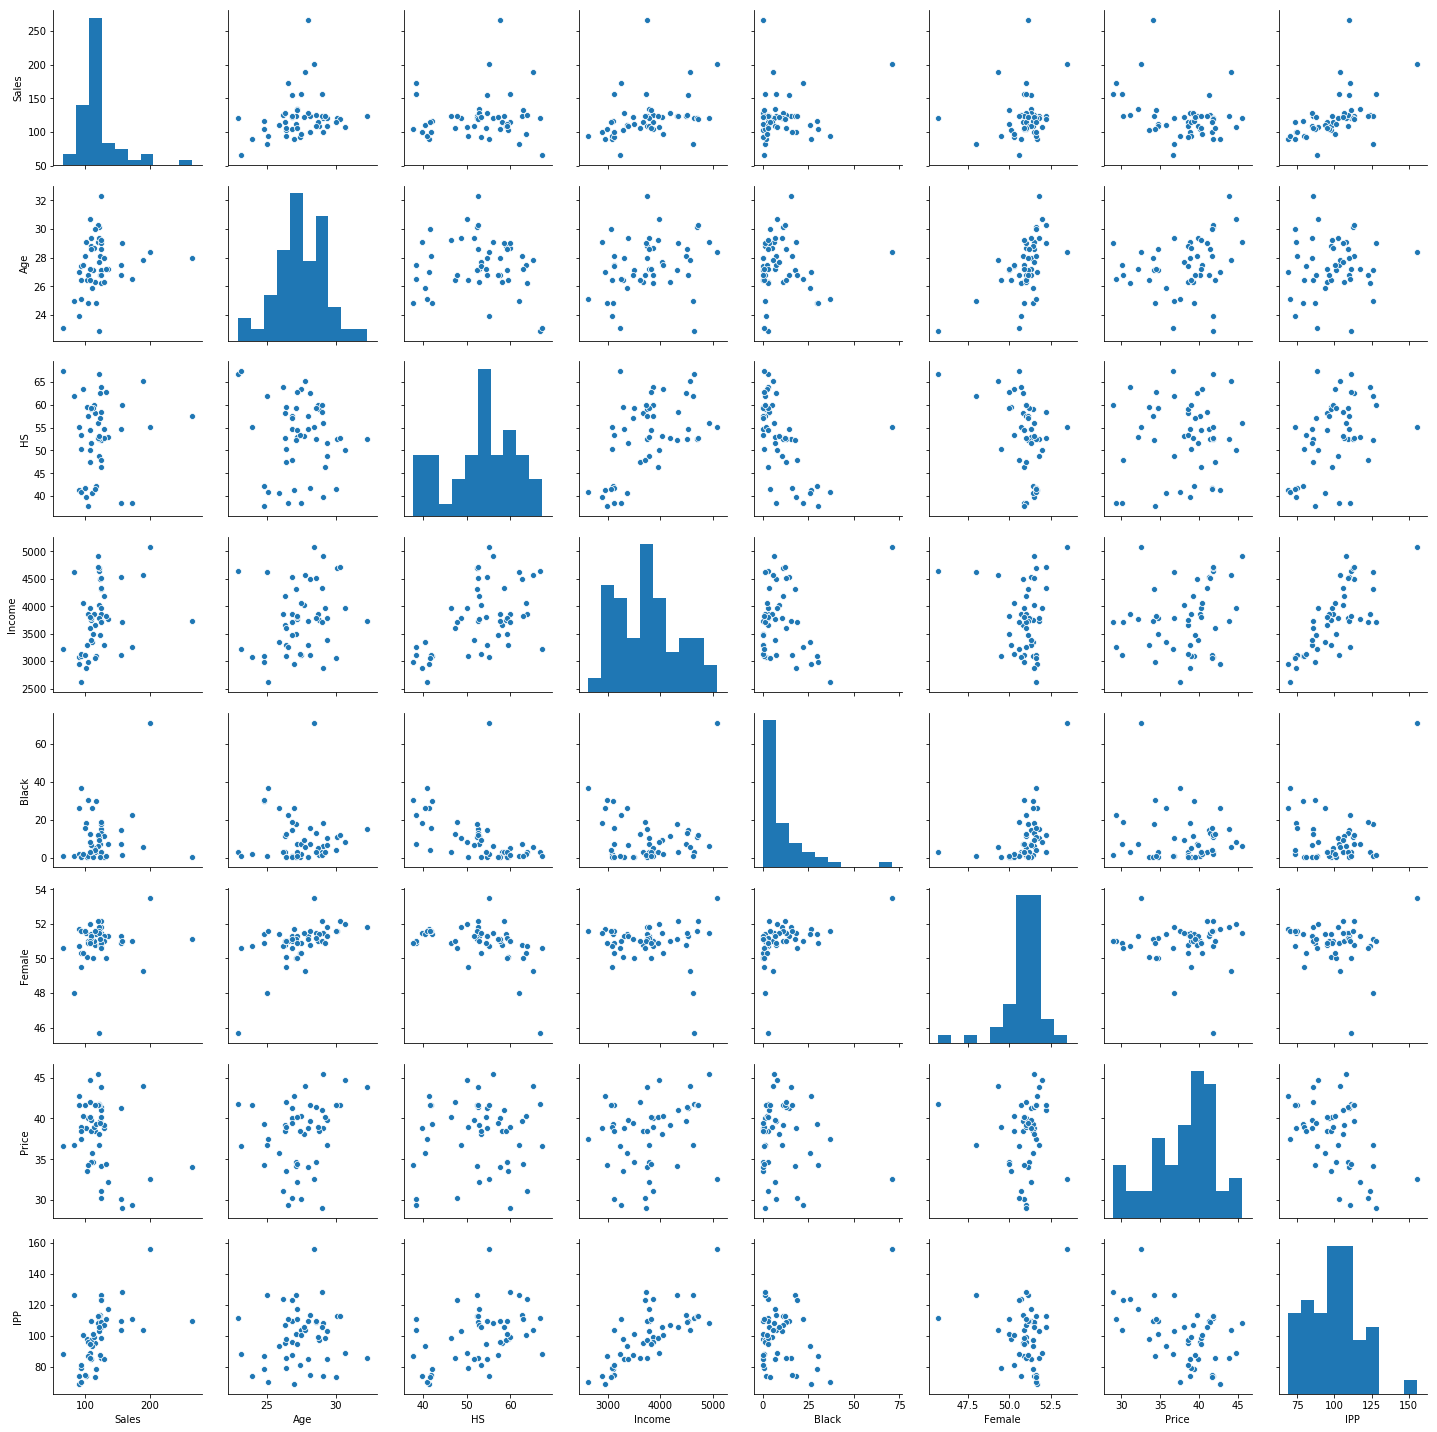

In [14]:
sns.pairplot(data)

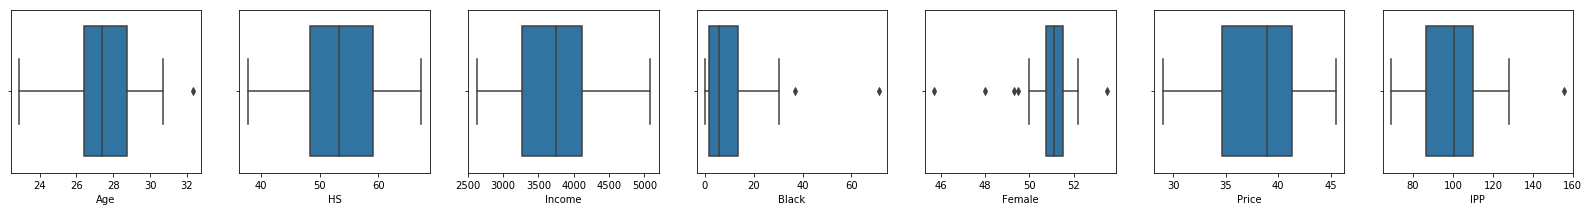

In [15]:
fig = plt.figure(figsize=(len(Variables.columns)*4, 3))
idx = 1
for li in Variables.columns :
    ax = fig.add_subplot(1, len(Variables.columns),idx)
    sns.boxplot(data = Variables, x = li)

    idx += 1

In [16]:
Target = np.log(data).Sales
Variables = np.log(data).drop("Sales", axis=1)

In [17]:
LR = sm.OLS.from_formula("np.log(Sales) ~ np.log(Age) + np.log(HS) + np.log(Income) + np.log(Black) + np.log(Female) + np.log(Price) + np.log(IPP)", data=data).fit()
LR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Sales)   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     4.993
Date:                Thu, 30 May 2019   Prob (F-statistic):           0.000562
Time:                        00:13:42   Log-Likelihood:                 16.654
No. Observations:                  51   AIC:                            -19.31
Df Residuals:                      44   BIC:                            -5.785
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.6036      6.396     -0.094      0.925     -13.494      12.287
np.log(Age)        0.7529      0.546      1.378      0.175      -0.348       1.854
np.log(HS)        -0.4408      0.342     -1.287      0.205      -1.131       0.249
np.log(Income)     0.2711      0.215      1.258      0.215      -0.163       0.705
np.log(Black)     -0.0170      0.030     -0.570      0.571      -0.077       0.043
np.log(Female)     0.2259      1.687      0.134      0.894      -3.175       3.627
np.log(Price)     -0.3078      0.191     -1.612      0.114      -0.693       0.077
np.log(IPP)        0.5789      0.130      4.455      0.000       0.317       0.841
==============================================================================
Omnibus:                       26.288   Durbin-Watson:                   1.723
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.104
Skew:                           1.390   Prob(JB):                     1.20e-14
Kurtosis:                       7.737   Cond. No.                     3.12e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.69e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

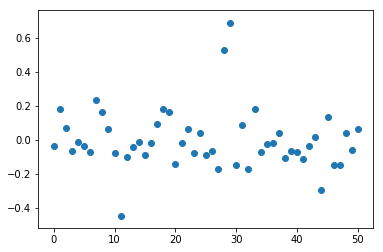

In [18]:
plt.scatter(range(len(LR.resid)), LR.resid )

In [19]:
Target = np.log(data).Sales
Variables = np.log(data).drop("Sales", axis=1)

0.3935218125434194
[ 0.54672098 -0.31293023  0.         -0.00610627  0.         -0.
  0.77173612]
0.001147644885583363


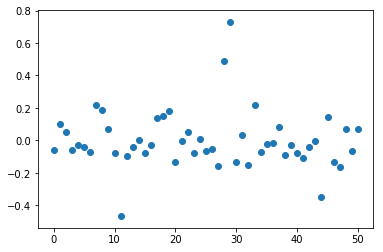

In [20]:
L = LassoCV(cv=5, fit_intercept=True).fit(Variables, Target)
print(L.score(Variables, Target))
print(L.coef_)
print(L.alpha_)
resid = Target - L.predict(Variables)
plt.scatter(range(len(resid)), resid)

0.3976201933753446
[ 0.55243255 -0.34576691  0.24914727 -0.00919837  0.11386143 -0.28261595
  0.53176322]
0.1


C:\Users\hawi7\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


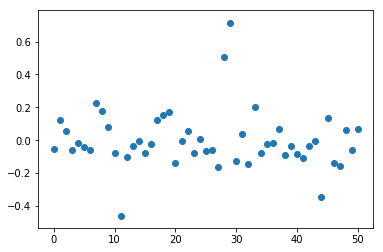

In [21]:
R = RidgeCV(cv=5, fit_intercept=True).fit(Variables, Target)
print(R.score(Variables, Target))
print(R.coef_)
print(R.alpha_)
resid = Target - R.predict(Variables)
plt.scatter(range(len(resid)), resid)

In [22]:
crit = np.log(data.Sales).std()
data_out = data[np.abs(LR.resid) < crit * 1]
data_outlier = data[np.abs(LR.resid) > crit * 1]

In [23]:
Target = np.log(data_out).Sales
Variables = np.log(data_out).drop("Sales", axis=1)

In [24]:
LR = sm.OLS.from_formula("np.log(Sales) ~ np.log(Age) + np.log(HS) + np.log(Income) + np.log(Black) + np.log(Female) + np.log(Price) + np.log(IPP)", data=data_out).fit()
LR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Sales)   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     13.20
Date:                Thu, 30 May 2019   Prob (F-statistic):           4.23e-08
Time:                        00:13:43   Log-Likelihood:                 44.662
No. Observations:                  46   AIC:                            -75.32
Df Residuals:                      39   BIC:                            -62.52
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4575      3.715      0.123      0.903      -7.057       7.972
np.log(Age)        0.2088      0.322      0.648      0.521      -0.443       0.861
np.log(HS)        -0.4174      0.199     -2.095      0.043      -0.820      -0.014
np.log(Income)     0.2372      0.122      1.941      0.060      -0.010       0.484
np.log(Black)     -0.0131      0.017     -0.759      0.452      -0.048       0.022
np.log(Female)     0.4906      1.018      0.482      0.633      -1.569       2.550
np.log(Price)     -0.3313      0.104     -3.183      0.003      -0.542      -0.121
np.log(IPP)        0.5685      0.075      7.614      0.000       0.417       0.720
==============================================================================
Omnibus:                        2.867   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.239   Jarque-Bera (JB):                2.310
Skew:                           0.415   Prob(JB):                        0.315
Kurtosis:                       2.282   Cond. No.                     1.31e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.96e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

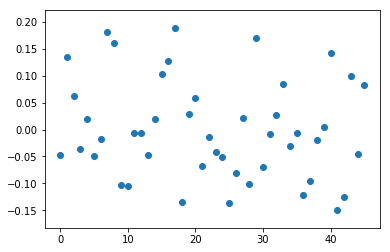

In [25]:
plt.scatter(range(len(LR.resid)), LR.resid )

0.6607244774449125
[ 0.15724018 -0.33413347  0.         -0.00432363  0.         -0.08829858
  0.75012593]
0.0006069217900888012
2.4492064426795617


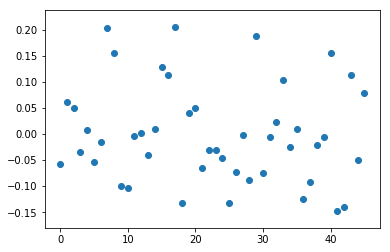

In [26]:
L = LassoCV(cv=5, fit_intercept=True).fit(Variables, Target)
print(L.score(Variables, Target))
print(L.coef_)
print(L.alpha_)
print(L.intercept_)
resid = Target - L.predict(Variables)
plt.scatter(range(len(resid)), resid)

0.6602331271917548
[ 0.20881077 -0.28046384  0.18350666 -0.00150744  0.08127688 -0.32382604
  0.5073327 ]
0.1


C:\Users\hawi7\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


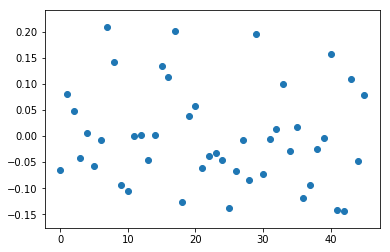

In [27]:
R = RidgeCV(cv=5, fit_intercept=True).fit(Variables, Target)
print(R.score(Variables, Target))
print(R.coef_)
print(R.alpha_)
resid = Target - R.predict(Variables)
plt.scatter(range(len(resid)), resid)

In [28]:
LR = sm.OLS.from_formula("np.log(Sales) ~ np.log(Age) + np.log(HS) + np.log(Income) + np.log(Black) + np.log(Price) + np.log(IPP)", data=data_out).fit()
LR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Sales)   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     16.10
Date:                Thu, 30 May 2019   Prob (F-statistic):           1.10e-08
Time:                        00:13:44   Log-Likelihood:                 44.525
No. Observations:                  46   AIC:                            -77.05
Df Residuals:                      40   BIC:                            -66.08
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.1831      0.976      2.238      0.031       0.211       4.155
np.log(Age)        0.3082      0.245      1.257      0.216      -0.187       0.804
np.log(HS)        -0.4183      0.197     -2.120      0.040      -0.817      -0.020
np.log(Income)     0.2267      0.119      1.903      0.064      -0.014       0.467
np.log(Black)     -0.0104      0.016     -0.644      0.524      -0.043       0.022
np.log(Price)     -0.3396      0.102     -3.342      0.002      -0.545      -0.134
np.log(IPP)        0.5663      0.074      7.673      0.000       0.417       0.716
==============================================================================
Omnibus:                        2.295   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.317   Jarque-Bera (JB):                2.074
Skew:                           0.423   Prob(JB):                        0.354
Kurtosis:                       2.396   Cond. No.                     1.23e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.98e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

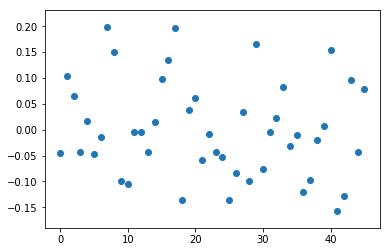

In [29]:
plt.scatter(range(len(LR.resid)), LR.resid )

In [30]:
LR = sm.OLS.from_formula("np.log(Sales) ~ np.log(Age) + np.log(HS) + np.log(Income) + np.log(Price) + np.log(IPP)", data=data_out).fit()
LR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Sales)   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     20.32
Date:                Thu, 30 May 2019   Prob (F-statistic):           2.74e-09
Time:                        00:13:44   Log-Likelihood:                 44.289
No. Observations:                  46   AIC:                            -78.58
Df Residuals:                      41   BIC:                            -69.43
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.2634      0.961      2.356      0.023       0.323       4.204
np.log(Age)        0.3374      0.239      1.411      0.166      -0.146       0.820
np.log(HS)        -0.3180      0.120     -2.647      0.011      -0.561      -0.075
np.log(Income)     0.1790      0.093      1.934      0.060      -0.008       0.366
np.log(Price)     -0.3624      0.095     -3.830      0.000      -0.553      -0.171
np.log(IPP)        0.5413      0.062      8.686      0.000       0.415       0.667
==============================================================================
Omnibus:                        2.193   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.334   Jarque-Bera (JB):                2.085
Skew:                           0.459   Prob(JB):                        0.353
Kurtosis:                       2.505   Cond. No.                     1.57e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.4e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

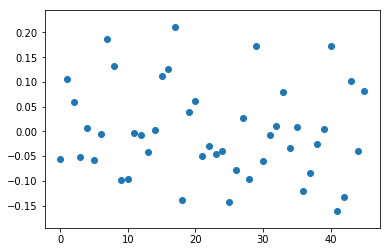

In [31]:
plt.scatter(range(len(LR.resid)), LR.resid )

In [32]:
LR = sm.OLS.from_formula("np.log(Sales) ~ np.log(HS) + np.log(Income) + np.log(Price) + np.log(IPP)", data=data_out).fit()
LR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Sales)   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     25.82
Date:                Thu, 30 May 2019   Prob (F-statistic):           1.26e-09
Time:                        00:13:44   Log-Likelihood:                 43.198
No. Observations:                  46   AIC:                            -78.40
Df Residuals:                      42   BIC:                            -71.08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.8868      0.863      3.345      0.002       1.145       4.628
np.log(HS)        -0.3499      0.119     -2.931      0.005      -0.591      -0.109
np.log(Income)     0.2307      0.086      2.686      0.010       0.057       0.404
np.log(Price)     -0.3192      0.091     -3.524      0.001      -0.502      -0.136
np.log(IPP)        0.5499      0.063      8.763      0.000       0.423       0.677
==============================================================================
Omnibus:                        2.135   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.344   Jarque-Bera (JB):                1.999
Skew:                           0.484   Prob(JB):                        0.368
Kurtosis:                       2.676   Cond. No.                     1.50e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.41e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

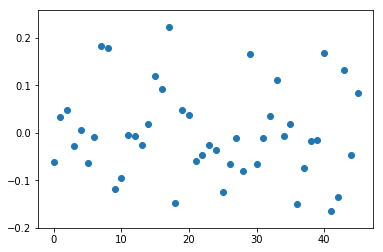

In [33]:
plt.scatter(range(len(LR.resid)), LR.resid )

In [34]:
pca = sm.PCA(Variables)

In [35]:
round(pca.eigenvals,2)

0    108.87
1     88.83
2     65.93
3     39.15
4     13.74
5      5.49
6      0.00
Name: eigenvals, dtype: float64

In [36]:
pc = pca.factors

In [37]:
pc = pc.drop("comp_6", axis=1)

In [38]:
LR = sm.OLS((Target-Target.mean())/Target.std(), pc).fit()
LR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     13.54
Date:                Thu, 30 May 2019   Prob (F-statistic):           2.54e-08
Time:                        00:13:44   Log-Likelihood:                -39.263
No. Observations:                  46   AIC:                             90.53
Df Residuals:                      40   BIC:                             101.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
comp_0         3.0410      0.609      4.991      0.000       1.810       4.272
comp_1        -2.4729      0.609     -4.059      0.000      -3.704      -1.242
comp_2         3.5034      0.609      5.750      0.000       2.272       4.735
comp_3         0.7444      0.609      1.222      0.229      -0.487       1.976
comp_4        -0.7885      0.609     -1.294      0.203      -2.020       0.443
comp_5        -1.1574      0.609     -1.900      0.065      -2.389       0.074
==============================================================================
Omnibus:                        2.867   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.239   Jarque-Bera (JB):                2.310
Skew:                           0.415   Prob(JB):                        0.315
Kurtosis:                       2.282   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

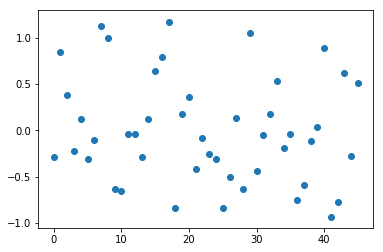

In [39]:
plt.scatter(range(len(LR.resid)), LR.resid )

In [40]:
data_outlier.head()

,Sales,Age,HS,Income,Black,Female,Price,IPP
State,,,,,,,,
DE,155.0,26.8,54.6,4524.0,14.3,51.3,41.3,109.539952
HI,82.1,25.0,61.9,4623.0,1.0,48.0,36.7,125.967302
NV,189.5,27.8,65.2,4563.0,5.7,49.3,44.0,103.704545
NH,265.7,28.0,57.6,3737.0,0.3,51.1,34.1,109.589443
UT,65.5,23.1,67.3,3227.0,0.6,50.6,36.6,88.169399


In [43]:
round(data.describe(),2)

,Sales,Age,HS,Income,Black,Female,Price,IPP
count,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00
mean,121.54,27.47,53.15,3763.71,9.99,50.95,38.07,99.74
std,32.07,1.88,8.00,594.72,12.65,1.11,4.13,17.55
min,65.50,22.90,37.80,2626.00,0.20,45.70,29.00,69.04
25%,105.35,26.40,48.30,3271.00,1.60,50.75,34.70,86.51
50%,119.00,27.40,53.30,3751.00,6.00,51.10,38.90,100.57
75%,124.55,28.75,59.10,4116.50,13.55,51.50,41.35,110.10
max,265.70,32.30,67.30,5079.00,71.10,53.50,45.50,155.80


In [44]:
L.predict(data_outlier.drop("Sales", axis=1))

array([66.87975457, 76.94380752, 58.91666754, 66.79944761, 46.49810215])

In [68]:
df = pd.concat([pd.Series(np.exp(L.predict(np.log(data_outlier.drop("Sales", axis=1))))),data_outlier.reset_index()], axis=1)
df = df.rename({0 : "Predicted"}, axis=1).set_index("State")

In [69]:
round(df,2)

,Predicted,Sales,Age,HS,Income,Black,Female,Price,IPP
State,,,,,,,,,
DE,123.04,155.0,26.8,54.6,4524.0,14.3,51.3,41.3,109.54
HI,132.47,82.1,25.0,61.9,4623.0,1.0,48.0,36.7,125.97
NV,111.75,189.5,27.8,65.2,4563.0,5.7,49.3,44.0,103.70
NH,125.90,265.7,28.0,57.6,3737.0,0.3,51.1,34.1,109.59
UT,97.60,65.5,23.1,67.3,3227.0,0.6,50.6,36.6,88.17
